# Bilevel ROF Scalar Parameter Learning
In this notebook we will propose an optimal parameter learning methodology for getting the optimal parameter for the scalar ROF image denoising model.
$$
\min \|\bar{u}-z\|^2 + \frac{\alpha}{2}\|\lambda\|^2\\
\text{s.t. }\langle \bar{u},v-\bar{u} \rangle + \lambda\|\mathbb{K}v\|_{2,1} - \lambda\|\mathbb{K}\bar{u}\|_{2,1} \ge \langle f,v-\bar{u} \rangle
$$
where $\|\cdot\|_{2,1}$ is the Total Variation seminorm.

In [88]:
using LinearAlgebra, StructuredOptimization, AbstractOperators, Plots, Distributed, Images

## Cost Function and Lower Level Solver

In [18]:
# Lower Level Solver
function lower_level_solver(u,f,λ,K)
    @minimize ls(-K'*u+f) + conj(λ*norm(u,2,1,2)) with ForwardBackward(tol = 1e-3, gamma = 1/8, fast = true) 
    return -K'*(~u)+f
end

# Upper level cost
function upper_level_cost(u,z,λ,α)
    return 0.5*norm(u[:]-z[:])^2 + 0.5*α*norm(λ)^2
end

upper_level_cost (generic function with 1 method)

In [250]:
m,n = 128,128
f = tril(ones(m,n)) + 0.5*randn(m,n)
f[f .< 0] .= 0.
f[f .> 1] .= 1.
z = tril(ones(m,n))
K = Variation(size(f))
u = Variable(size(K,1)...)
α = 0.1

0.1

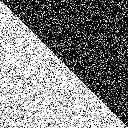

In [251]:
Gray.(f)

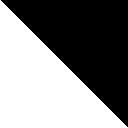

In [252]:
Gray.(z)

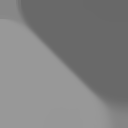

In [265]:
u_h = lower_level_solver(u,f,10,K)
Gray.(u_h)

In [260]:
step = 0.01
lambda_max = 15
lambda_min = eps()
lambda_range = lambda_min:step:lambda_max
costs = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    push!(costs,upper_level_cost(u_h,z,λ,α))
    #println("$λ")
end
println("done")

done


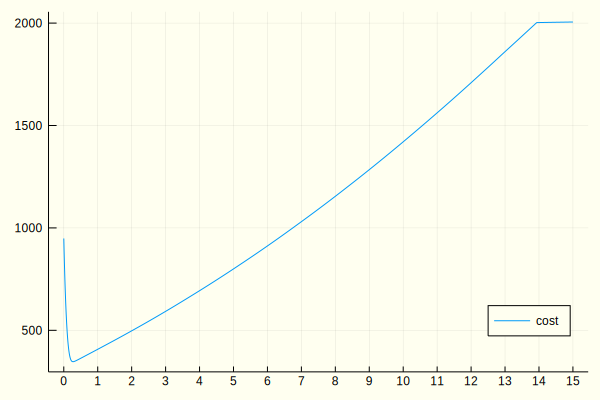

In [268]:
plot(lambda_range,costs,label="cost",xticks = 0:1:lambda_max, background_color = :ivory, legend=:bottomright)

## Gradient Calculation

In [278]:
include("gradient_solver.jl")

gradient_solver (generic function with 2 methods)

In [280]:
λ = 1.1
∇ = gradient_matrix(size(f))
u_h= lower_level_solver(u,f,λ,K)
grad = gradient_solver(u_h,z,λ,α,K,∇)

810.1646244720233

In [281]:
∇ = gradient_matrix(size(f))
K = Variation(size(f))
α = 0.1

0.1

In [284]:
step = 0.1
lambda_max = 3
lambda_min = eps()
lambda_range = lambda_min:step:lambda_max
grads = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    g = gradient_solver(u_h,z,λ,α,K,∇)
    push!(grads,g)
    println("$λ -> $g")
end
println("done")

done
2.220446049250313e-16 -> 751.0621241778915
0.10000000000000023 -> 626.7396175762674
0.20000000000000023 -> 607.7575321947597
0.30000000000000027 -> 620.031308658247
0.40000000000000024 -> 640.5194119017506
0.5000000000000002 -> 661.8378862553294
0.6000000000000003 -> 683.3764085872983
0.7000000000000003 -> 705.2272226944792
0.8000000000000003 -> 727.7859207906981
0.9000000000000002 -> 751.4632941225176
1.0000000000000002 -> 777.3356981911728
1.1000000000000003 -> 809.8813147177176
1.2000000000000004 -> 811.8075386450489
1.3000000000000003 -> 837.1567207307966
1.4000000000000004 -> 883.8712718309378
1.5000000000000002 -> 688.736949206905
1.6000000000000003 -> 484.8614510935456
1.7000000000000004 -> 915.1622543621794
1.8000000000000003 -> 929.5775909831901
1.9000000000000004 -> 969.5085822820215
2.0 -> 1043.937690684358
2.1000000000000005 -> 1059.1734848275614
2.2 -> 1074.7231449745389
2.3000000000000007 -> 1100.0638791585468
2.4000000000000004 -> 1249.495926621469
2.5 -> 1168.07079

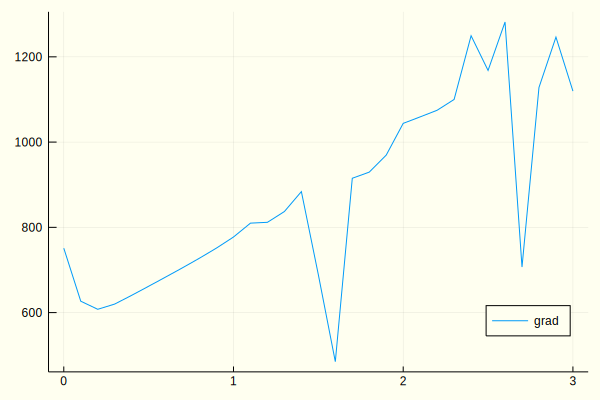

In [286]:
plot(lambda_range,grads,label="grad",xticks = 0:1:lambda_max, background_color = :ivory, legend=:bottomright)